# Coupled Cluster Reference Data Processing

* Counterpoise correction
* Basis set extrapolation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error

DATA_DIR = f"../data/HeBz"

cc_res = np.load(f"{DATA_DIR}/CC_HeBz_50.npy", allow_pickle=True).item()

to_kcal = (627.509, "kcal/mol")
to_mev = (27.2114 * 1000, "meV")
to_hartree = (1, "Hartree")
to_cm_1 = (2.194746 * 10**5, r"$\mathrm{cm}^{-1}$")
to_K = (3.1577464 * 10**5, "K")

energy_unit = to_cm_1

In [2]:
def helgaker_hf_cbs(E_x, E_y):
    a = 1.63
    return (E_y - (E_x * np.exp(-a))) / (1 - np.exp(-a))

def cc_helgaker_cbs_2pts(E_X, E_Y, X, Y):
    return (E_X * X**3 - E_Y * Y**3) / (X**3 - Y**3)

CCSD(T)/CBS_TQ: Distance:3.1275  Min energy: -90.232 MAE: 0.0
CCSD(T)/CBS_DT: Distance: 3.145, Min energy: -90.969 MAE: 1.9574316849354623 
CCSD(T)/aug-cc-pVQZ: Distance: 3.145, Min energy: -86.320 MAE: 14.881454073356885 
CCSD(T)/aug-cc-pVTZ: Distance: 3.18, Min energy: -81.455 MAE: 35.746805756465605 
CCSD(T)/aug-cc-pVDZ: Distance: 3.3200000000000003, Min energy: -61.041 MAE: 123.38833433030776 


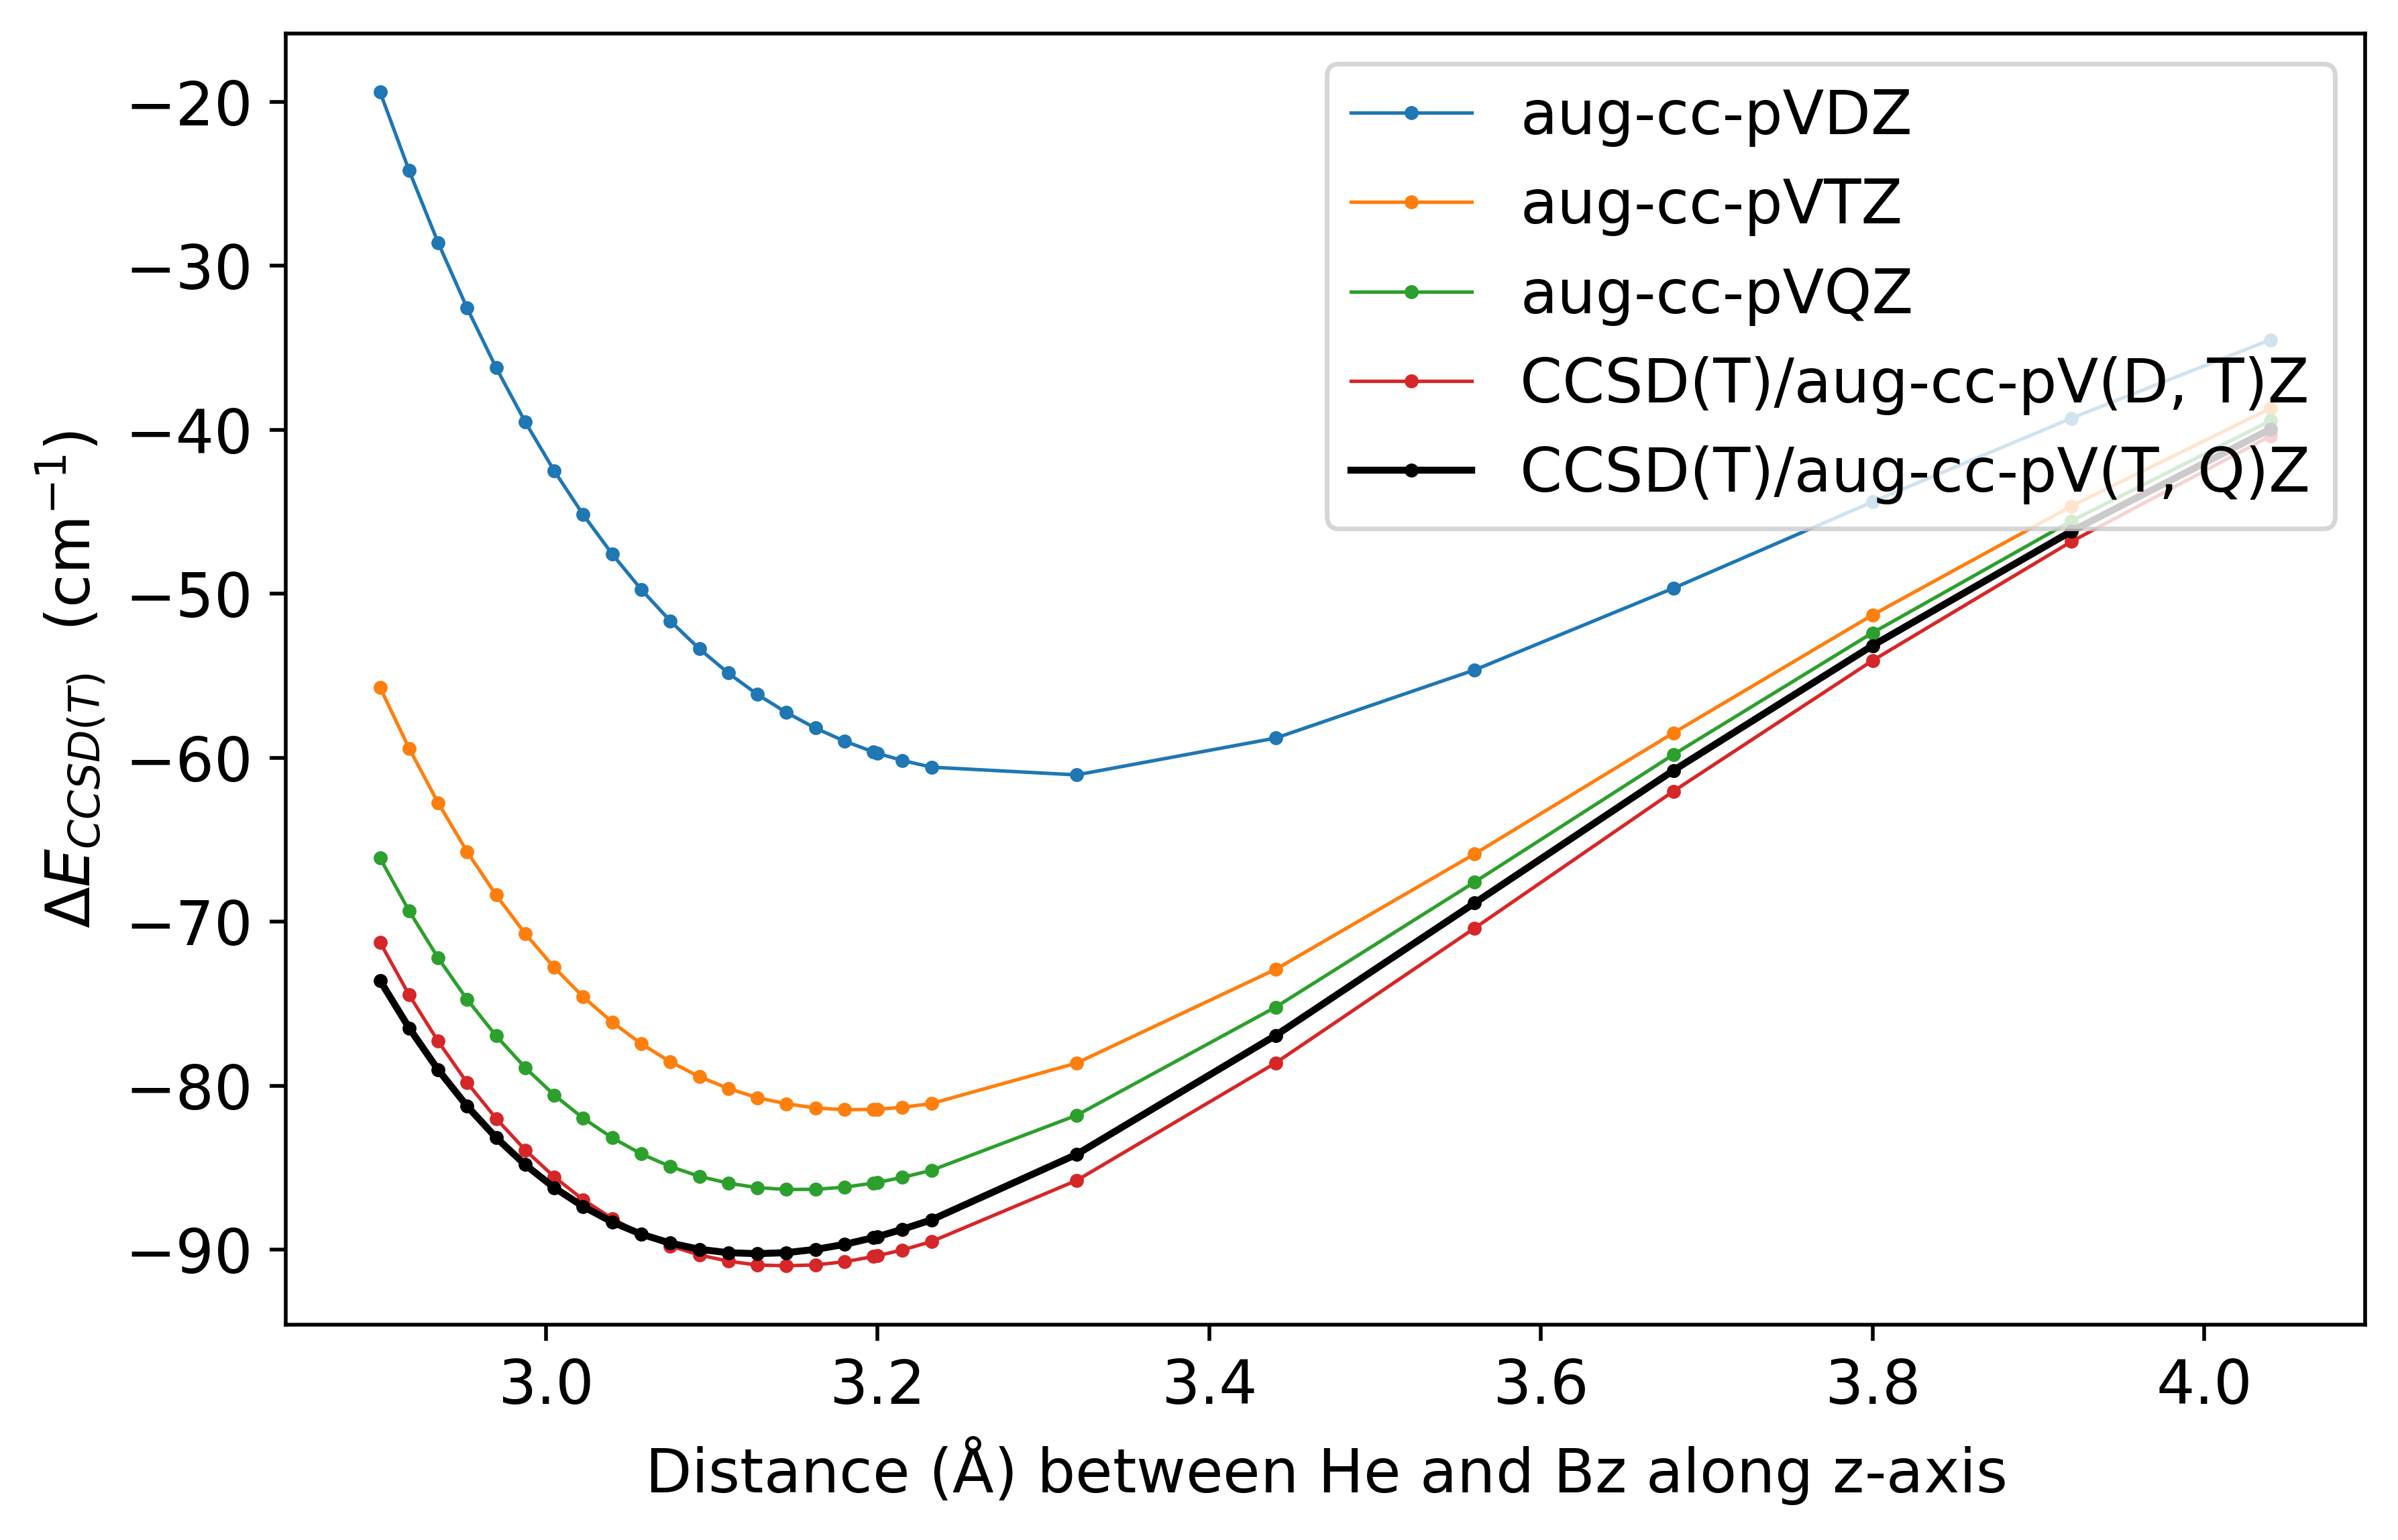

In [4]:
cp_correction = True
explt_hf = True


distances = list(cc_res.keys())


sorted_distances = sorted(distances, key=lambda x: float(x))

results = {}

for distance in sorted_distances:

    results[distance] = {}
    basis_sets = cc_res[distance]

    for basis_set in basis_sets.keys():

        results[distance][basis_set] = {}

        hf_hebz = basis_sets[basis_set]["HeBz"]["rhf"]
        hf_he_gbz = basis_sets[basis_set]["He_gBz"]["rhf"]
        hf_bz_ghe = basis_sets[basis_set]["Bz_gHe"]["rhf"]

        hf_en = hf_hebz - hf_he_gbz - hf_bz_ghe if cp_correction else hf_hebz

        sd_hebz = basis_sets[basis_set]["HeBz"]["sd"]
        sd_he_gbz = basis_sets[basis_set]["He_gBz"]["sd"]
        sd_bz_ghe = basis_sets[basis_set]["Bz_gHe"]["sd"]

        sd_en = sd_hebz - sd_he_gbz - sd_bz_ghe if cp_correction else sd_hebz

        t_hebz = (
            basis_sets[basis_set]["HeBz"]["td"] + basis_sets[basis_set]["HeBz"]["ts"]
        )
        t_he_gbz = (
            basis_sets[basis_set]["He_gBz"]["td"]
            + basis_sets[basis_set]["He_gBz"]["ts"]
        )
        t_bz_ghe = (
            basis_sets[basis_set]["Bz_gHe"]["td"]
            + basis_sets[basis_set]["Bz_gHe"]["ts"]
        )

        t_en = t_hebz - t_he_gbz - t_bz_ghe if cp_correction else t_hebz

        results[distance][basis_set]["hf"] = hf_en
        results[distance][basis_set]["sd"] = sd_en
        results[distance][basis_set]["t"] = t_en

    hf_dz = results[distance]["aug-cc-pVDZ"]["hf"]
    hf_tz = results[distance]["aug-cc-pVTZ"]["hf"]
    hf_qz = results[distance]["aug-cc-pVQZ"]["hf"]

    hf_cbs_dt = helgaker_hf_cbs(hf_dz, hf_tz) if explt_hf else hf_tz
    hf_cbs_tq = helgaker_hf_cbs(hf_tz, hf_qz) if explt_hf else hf_qz

    cc_sd_cbs_dt = cc_helgaker_cbs_2pts(
        results[distance]["aug-cc-pVDZ"]["sd"],
        results[distance]["aug-cc-pVTZ"]["sd"],
        2,
        3,
    )

    cc_t_cbs_dt = cc_helgaker_cbs_2pts(
        results[distance]["aug-cc-pVDZ"]["t"],
        results[distance]["aug-cc-pVTZ"]["t"],
        2,
        3,
    )

    cc_sd_cbs_tq = cc_helgaker_cbs_2pts(
        results[distance]["aug-cc-pVTZ"]["sd"],
        results[distance]["aug-cc-pVQZ"]["sd"],
        3,
        4,
    )

    cc_t_cbs_tq = cc_helgaker_cbs_2pts(
        results[distance]["aug-cc-pVTZ"]["t"],
        results[distance]["aug-cc-pVQZ"]["t"],
        3,
        4,
    )

    results[distance]["cbs-dt"] = {
        "hf": hf_cbs_dt,
        "sd": cc_sd_cbs_dt,
        "t": cc_t_cbs_dt,
    }

    results[distance]["cbs-tq"] = {
        "hf": hf_cbs_tq,
        "sd": cc_sd_cbs_tq,
        "t": cc_t_cbs_tq,
    }


sorted_res = []

for distance in sorted_distances:
    sorted_res.append((distance, results[str(distance)]))


sorted_results = sorted_res


aug_cc_pVDZ = [
    [
        (
            result[1]["aug-cc-pVDZ"]["hf"]
            + result[1]["aug-cc-pVDZ"]["sd"]
            + result[1]["aug-cc-pVDZ"]["t"]
        )
        * energy_unit[0],
    ]
    for result in sorted_results
]


aug_cc_pVTZ = [
    [
        (
            result[1]["aug-cc-pVTZ"]["hf"]
            + result[1]["aug-cc-pVTZ"]["sd"]
            + result[1]["aug-cc-pVTZ"]["t"]
        )
        * energy_unit[0],
    ]
    for result in sorted_results
]


aug_cc_pVQZ = [
    [
        (
            result[1]["aug-cc-pVQZ"]["hf"]
            + result[1]["aug-cc-pVQZ"]["sd"]
            + result[1]["aug-cc-pVQZ"]["t"]
        )
        * energy_unit[0],
    ]
    for result in sorted_results
]


cbs_tq = [
    [
        (
            result[1]["cbs-tq"]["hf"]
            + result[1]["cbs-tq"]["sd"]
            + result[1]["cbs-tq"]["t"]
        )
        * energy_unit[0]
    ]
    for result in sorted_results
]

cbs_dt = [
    [
        (
            result[1]["cbs-dt"]["hf"]
            + result[1]["cbs-dt"]["sd"]
            + result[1]["cbs-dt"]["t"]
        )
        * energy_unit[0],
    ]
    for result in sorted_results
]


calc_start = 0
calc_end = -1


def compute_mae(reference, target):

    reference = reference[calc_start:calc_end]
    target = target[calc_start:calc_end]

    return mean_absolute_error(reference, target)


print(
    f"CCSD(T)/CBS_TQ: Distance:{sorted_distances[np.argmin(cbs_tq)]}  Min energy: {np.min(np.array(cbs_tq)):.3f} MAE: {compute_mae(cbs_tq, cbs_tq)}"
)
print(
    f"CCSD(T)/CBS_DT: Distance: {sorted_distances[np.argmin(cbs_dt)]}, Min energy: {np.min(cbs_dt):.3f} MAE: {compute_mae(cbs_tq, cbs_dt)} "
)

print(
    f"CCSD(T)/aug-cc-pVQZ: Distance: {sorted_distances[np.argmin(aug_cc_pVQZ)]}, Min energy: {np.min(aug_cc_pVQZ):.3f} MAE: {compute_mae(cbs_tq, aug_cc_pVQZ)} "
)
print(
    f"CCSD(T)/aug-cc-pVTZ: Distance: {sorted_distances[np.argmin(aug_cc_pVTZ)]}, Min energy: {np.min(aug_cc_pVTZ):.3f} MAE: {compute_mae(cbs_tq, aug_cc_pVTZ)} "
)
print(
    f"CCSD(T)/aug-cc-pVDZ: Distance: {sorted_distances[np.argmin(aug_cc_pVDZ)]}, Min energy: {np.min(aug_cc_pVDZ):.3f} MAE: {compute_mae(cbs_tq, aug_cc_pVDZ)} "
)


line_width = 0.75

start_pt_cc_plt = 5
end_pt_cc_plt = 33

plot_distances = [float(d[0].split("___")[-1]) for d in sorted_results][
    start_pt_cc_plt:end_pt_cc_plt
]

plt.figure(figsize=(8, 5))
plt.gcf().set_dpi(500)


def plot_energy_curve(
    distances, energies, label, linewidth=1.0, linestyle="-", color=None
):
    plt.plot(
        distances,
        energies,
        label=label,
        linewidth=linewidth,
        linestyle=linestyle,
        marker="o",
        markersize=2,
        color=color,
    )


plot_energy_curve(
    plot_distances,
    aug_cc_pVDZ[start_pt_cc_plt:end_pt_cc_plt],
    label="aug-cc-pVDZ",
    linewidth=line_width,
)

plot_energy_curve(
    plot_distances,
    aug_cc_pVTZ[start_pt_cc_plt:end_pt_cc_plt],
    label="aug-cc-pVTZ",
    linewidth=line_width,
)


plot_energy_curve(
    plot_distances,
    aug_cc_pVQZ[start_pt_cc_plt:end_pt_cc_plt],
    label="aug-cc-pVQZ",
    linewidth=line_width,
)


plot_energy_curve(
    plot_distances,
    cbs_dt[start_pt_cc_plt:end_pt_cc_plt],
    label="CCSD(T)/aug-cc-pV(D, T)Z",
    linewidth=line_width,
)

plot_energy_curve(
    plot_distances,
    cbs_tq[start_pt_cc_plt:end_pt_cc_plt],
    label="CCSD(T)/aug-cc-pV(T, Q)Z",
    linewidth=line_width * 2,
    color="black",
)

font_size = 13

plt.rc("font", size=10)
plt.rc("xtick", labelsize=font_size)
plt.rc("ytick", labelsize=font_size)


plt.xlabel(
    r"Distance ($\mathrm{\AA}$) between He and Bz along z-axis", fontsize=font_size
)
plt.ylabel(r"$\Delta E_{CCSD(T)}$" + f"  ({energy_unit[1]})", fontsize=font_size)

plt.legend(loc="upper right", fontsize=font_size)

plt.show()

# final_dat = (
#     {
#         "distances": distances,
#         # "aug_cc_pVDZ": aug_cc_pVDZ,
#         # "aug_cc_pVTZ": aug_cc_pVTZ,
#         # "aug_cc_pVQZ": aug_cc_pVQZ,
#         "cbs_dt": cbs_dt,
#         "cbs_tq": cbs_tq,
#     },
# )